In [6]:
import requests
import re
import json

def extract_json_from_html(url, save_output=False):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Failed to retrieve the HTML content. Status code: {}".format(response.status_code)

    html = response.text
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    match = re.findall(regex_pattern, html)
    if not match:
        return "No match found"

    # Correcting data format by adding quotes around keys
    data_txt = match[0]
    keys_to_replace = ['matchId', 'matchCentreData', 'matchCentreEventTypeJson', 'formationIdNameMappings']
    for key in keys_to_replace:
        data_txt = data_txt.replace(key, f'"{key}"')
    data_txt = data_txt.replace('};', '}')

    # Try to parse the JSON data
    try:
        data_json = json.loads(data_txt)
    except json.JSONDecodeError:
        return "JSON decoding failed"

    # Print the JSON structure summarization
    print_json_structure(data_json)

    # Optionally, save the JSON data to a text file
    if save_output:
        output_filename = 'output.txt'
        with open(output_filename, 'w', encoding='utf-8') as output_file:
            json.dump(data_json, output_file, indent=4)

    return data_json

def print_json_structure(data, indent=0, max_list_example=3):
    for key, value in data.items():
        if isinstance(value, dict):
            print('  ' * indent + f"{key} (dict with {len(value.keys())} keys)")
            print_json_structure(value, indent + 1)
        elif isinstance(value, list):
            print('  ' * indent + f"{key} (list with {len(value)} items)")
            if value:
                if isinstance(value[0], dict):
                    print('  ' * (indent + 1) + f"Example item from list:")
                    print_json_structure(value[0], indent + 2)
                else: 
                    example_items = value[:max_list_example]
                    print('  ' * (indent + 1) + f"Example items: {example_items}")
        else:
            print('  ' * indent + f"{key} ({type(value).__name__})")



In [7]:
## replace with the match wanted to scrape
url = "https://www.whoscored.com/Matches/1734900/Live/Spain-LaLiga-2023-2024-Barcelona-Valencia"
data = extract_json_from_html(url, save_output=True)


matchId (int)
matchCentreData (dict with 28 keys)
  playerIdNameDictionary (dict with 43 keys)
    300447 (str)
    437157 (str)
    130331 (str)
    301019 (str)
    77464 (str)
    80774 (str)
    29400 (str)
    128967 (str)
    362431 (str)
    498386 (str)
    367164 (str)
    402197 (str)
    454343 (str)
    463838 (str)
    480249 (str)
    483206 (str)
    349760 (str)
    84008 (str)
    90780 (str)
    90782 (str)
    106885 (str)
    497922 (str)
    384711 (str)
    430083 (str)
    401633 (str)
    384578 (str)
    322246 (str)
    367180 (str)
    371599 (str)
    354526 (str)
    136810 (str)
    295964 (str)
    302889 (str)
    392686 (str)
    408732 (str)
    431507 (str)
    475551 (str)
    425591 (str)
    429421 (str)
    383091 (str)
    504417 (str)
    510999 (str)
    422656 (str)
  periodMinuteLimits (dict with 4 keys)
    1 (int)
    2 (int)
    3 (int)
    4 (int)
  timeStamp (str)
  attendance (int)
  venueName (str)
  referee (dict with 5 keys)
    offi

In [8]:
import pandas as pd
import json

def extract_data_from_dict(data):
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {
        data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
        data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']
    }
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]

    # Creating players dataframes
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']

    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']

    # Combine the home and away players into a single DataFrame
    players_df = pd.concat([players_home_df, players_away_df], ignore_index=True)

    return events_dict, players_df, teams_dict


In [9]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes

In [10]:
events_dict, players_df, teams_dict = extract_data_from_dict(data)
print(teams_dict)
passes_df = get_passes_df(events_dict)
passes_df.head()

{65: 'Barcelona', 55: 'Valencia'}


,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.680657e+09,50.0,50.0,30.4,37.1,65,463838.0,301019.0,Pass,Successful
3,2.680657e+09,31.1,34.1,63.7,53.5,65,301019.0,431507.0,Pass,Unsuccessful
6,2.680657e+09,28.8,30.8,46.4,41.6,55,431507.0,384711.0,Pass,Unsuccessful
9,2.680657e+09,37.8,22.2,44.2,28.7,55,430083.0,354526.0,Pass,Successful
10,2.680657e+09,45.0,27.6,69.0,0.0,55,354526.0,128967.0,Pass,Unsuccessful


In [11]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    print(team_id)
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    print(average_locs_and_count_df)

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

In [12]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)

65
                  x          y  count                   name  shirtNo position
playerId                                                                      
29400.0   67.745455  47.990909     11     Robert Lewandowski        9       FW
77464.0   56.138384  51.327273     99         Ilkay Gündogan       22       MC
80774.0   15.540000  49.180000     30  Marc-André ter Stegen        1       GK
128967.0  60.195455  85.251515     66           João Cancelo        2       DL
130331.0  58.275862  39.331034     29    Andreas Christensen       15       MC
300447.0  65.166667  64.270370     27               Raphinha       11      FWL
301019.0  54.187597  21.244186    129           Jules Koundé       23       DR
384711.0  40.768478  44.697826     92          Ronald Araujo        4       DC
463838.0  61.381250  34.165625     32           Fermín López       16       MC
480249.0  71.987013  12.850649     77           Lamine Yamal       27      FWR
498386.0  47.762069  78.862069     58            

In [13]:
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

55
                  x          y  count                  name  shirtNo position
playerId                                                                     
302889.0  41.635000  47.760000     20                Pepelu       18       MC
322246.0  48.200000  38.650000      8         André Almeida       10       FW
354526.0  52.400000  53.869231     13             Hugo Duro        9       FW
367180.0  37.396154   9.430769     26       Thierry Correia       12       DR
401633.0  10.933333  50.606667     15  Giorgi Mamardashvili       25       GK
408732.0  39.023077  93.423077     13         Jesús Vázquez       21       DL
422656.0  40.563636  78.100000     11           Diego López       16       ML
425591.0  27.206250  31.206250     16    Cristhian Mosquera        3       DC
430083.0  58.358333  19.625000     12        Peter González       11       MR
431507.0  38.526667  41.246667     15           Javi Guerra        8       MC
504417.0  32.742857  77.078571     14     Yarek Gasiorowski  

### Visualization

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager

In [15]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size, marker='h',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        print(row)
        player_name = row["name"].split()
        player_shirt_no = row["shirtNo"]
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_shirt_no, xy=(row.x, row.y), c='#C4C4C4', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

x                       67.745455
y                       47.990909
count                          11
name           Robert Lewandowski
shirtNo                         9
position                       FW
marker_size            255.813953
Name: 29400.0, dtype: object
x                   56.138384
y                   51.327273
count                      99
name           Ilkay Gündogan
shirtNo                    22
position                   MC
marker_size       2302.325581
Name: 77464.0, dtype: object
x                              15.54
y                              49.18
count                             30
name           Marc-André ter Stegen
shirtNo                            1
position                          GK
marker_size               697.674419
Name: 80774.0, dtype: object
x                 60.195455
y                 85.251515
count                    66
name           João Cancelo
shirtNo                   2
position                 DL
marker_size     1534.883721
Name: 1289

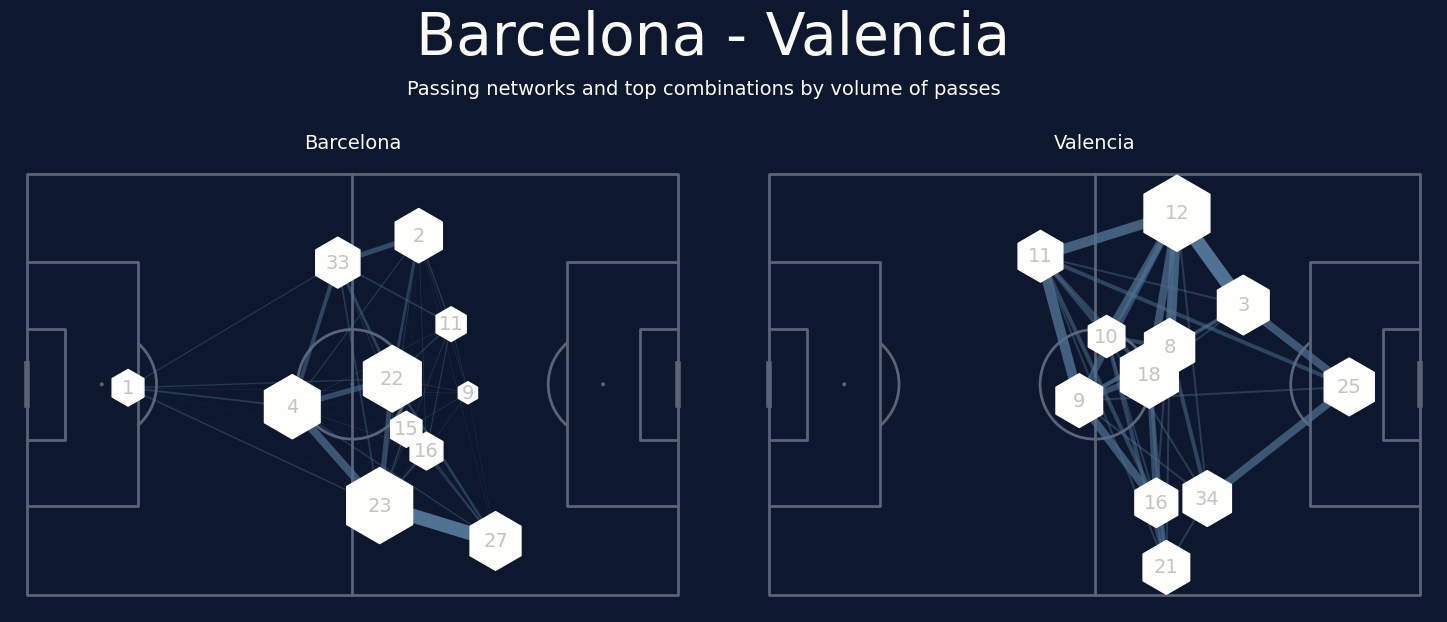

In [16]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#0D182E")

# plot variables
main_color = '#FBFAF5'

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14 )

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
plt.savefig('output.png', bbox_inches='tight')
plt.show()